In [3]:
# 1. Imports

# Basic Stuff
import numpy as np
import pandas as pd
import os
import random

# Training Stuff
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import (Dataset, TensorDataset, DataLoader, Subset)
from collections import OrderedDict

# Evaluation Stuff
from sklearn.metrics import mean_squared_error

# Plotting Stuff
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Superpowers
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Connecting to GoogleDrive
from google.colab import drive
import os
drive.mount('/content/gdrive')

PATH_TO_DATA = '/content/gdrive/MyDrive/Code/AI4Finance/data' # please change this according to your needs

Mounted at /content/gdrive


In [5]:
!nvidia-smi if device == 'cuda'

Sat Jun 18 09:02:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Helper Functions
def create_input_data(series, n_lags=1, n_leads=1):
    '''
    Function for transforming time series into input acceptable by a multilayer perceptron.
    
    Parameters
    ----------
    series : np.array
        The time series to be transformed
    n_lags : int
        The number of lagged observations to consider as features
    n_leads : int
        The number of future periods we want to forecast for
        
    Returns
    -------
    X : np.array
        Array of features
    y : np.array
        Array of target
    '''
    X = []
    y = []
    for step in range(len(series) - n_lags - n_leads + 1):
        end_step = step + n_lags
        forward_end = end_step + n_leads
        X.append(series[step:end_step])
        y.append(series[end_step:forward_end])
    return np.array(X), np.array(y)

# custom function for reproducibility


def custom_set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [9]:
from datetime import time
# 2 Define Parameters
END_DATE = '2022-06-16 19:00:00'
VALID_START = '2022-06-16 15:00:00'
N_LAGS = 12
# neural network
BATCH_SIZE = 24
N_EPOCHS = 1000

In [10]:
# 3 Get Refinitiv data and Clean it up
df = pd.read_excel(PATH_TO_DATA + '/Price History_20220616_1915.xlsx', usecols="A:I", skiprows=range(0,16), header=0)
df['datetime'] = df['Local Date']

df = df[['datetime', 'Close', '%Chg', 'Volume']]
df.dropna(axis=0, inplace=True)
df.set_index('datetime', inplace=True)

valid_size = df[(df.index > VALID_START) & (df.index < END_DATE)].shape[0]
prices = df['Close'].values

df

,Close,%Chg,Volume
datetime,,,
2022-06-16 19:00:00,131.0400,0.001346,152201.0
2022-06-16 18:59:00,130.8639,-0.000276,82634.0
2022-06-16 18:58:00,130.9000,0.000037,90831.0
2022-06-16 18:57:00,130.8952,0.000431,90186.0
2022-06-16 18:56:00,130.8388,-0.000477,113039.0
...,...,...,...
2022-06-13 10:06:00,133.4400,0.001501,7415.0
2022-06-13 10:05:00,133.2400,-0.000900,4411.0
2022-06-13 10:04:00,133.3600,0.000675,6223.0


In [11]:
# 4. Prepare data to feed to CNN
X, y = create_input_data(prices, N_LAGS)

In [12]:
# 5. Obtain the naïve forecast
naive_pred = prices[len(prices) - valid_size - 1:-1]
y_valid = prices[len(prices) - valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print('Naïve forecast - MSE: {:.2f}, RMSE: {:.2f}'.format(naive_mse, naive_rmse))

Naïve forecast - MSE: 0.01, RMSE: 0.09


In [13]:
# 6. Define DataLoader objects
# setting seed for reproducibility
custom_set_seed(42)

valid_ind = len(X) - valid_size

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE)


In [14]:
# 7. Define CNN
class Flatten(nn.Module):
  def forward(self, x):
      return x.view(x.size()[0], -1)
model = nn.Sequential(OrderedDict([
    ('conv_1', nn.Conv1d(1, 32, 3, padding=1)),
    ('max_pool_1', nn.MaxPool1d(2)),
    ('relu_1', nn.ReLU()),
    ('flatten', Flatten()),
    ('fc_1', nn.Linear(192, 50)),
    ('relu_2', nn.ReLU()),
    ('dropout_1', nn.Dropout(0.4)),
    ('fc_2', nn.Linear(50, 1))
]))

model

Sequential(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (flatten): Flatten()
  (fc_1): Linear(in_features=192, out_features=50, bias=True)
  (relu_2): ReLU()
  (dropout_1): Dropout(p=0.4, inplace=False)
  (fc_2): Linear(in_features=50, out_features=1, bias=True)
)

In [15]:
# 8. Instantiate model, loss function, optimizer
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [16]:
# 9. Train the CNN
PRINT_EVERY = 50
train_losses = []
valid_losses = []

print('Training mode: 🚀\n' if device=='cuda' else 'Training mode: 🐢\n')


for epoch in range(N_EPOCHS):
  running_loss_train = 0
  running_loss_valid = 0

  model.train()
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad()
    x_batch = x_batch.to(device)
    x_batch = x_batch.view(x_batch.shape[0], 1, N_LAGS)
    y_batch = y_batch.to(device)
    y_batch = y_batch.view(y_batch.shape[0], 1, 1)
    y_hat = model(x_batch).view(y_batch.shape[0], 1, 1)
    loss = torch.sqrt(loss_fn(y_batch, y_hat))
    loss.backward()
    optimizer.step()
    running_loss_train += loss.item() * x_batch.size(0)
  epoch_loss_train = running_loss_train / len(train_loader.dataset)
  train_losses.append(epoch_loss_train)

  with torch.no_grad():
    model.eval()
    for x_val, y_val in valid_loader:
      x_val = x_val.to(device)
      x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
      y_val = y_val.to(device)
      y_val = y_val.view(y_val.shape[0], 1, 1)
      y_hat = model(x_val).view(y_val.shape[0], 1, 1)
      loss = torch.sqrt(loss_fn(y_val, y_hat))
      running_loss_valid += loss.item() * x_val.size(0)
    epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
    if epoch > 0 and epoch_loss_valid < min(valid_losses):
      best_epoch = epoch
      torch.save(model.state_dict(), './cnn_checkpoint.pth')
    valid_losses.append(epoch_loss_valid)

  if epoch % PRINT_EVERY == 0:
    print("<{}> - Train. loss: {:.6f} \t Valid. loss: {:.6f}".format(epoch, epoch_loss_train, epoch_loss_valid))

print("Lowest loss recorded in epoch: {}".format(best_epoch))


Training mode: 🚀

<0> - Train. loss: 31.763759 	 Valid. loss: 5.989254
<50> - Train. loss: 25.981632 	 Valid. loss: 12.279375
<100> - Train. loss: 24.586555 	 Valid. loss: 8.552105
<150> - Train. loss: 22.993143 	 Valid. loss: 5.497512
<200> - Train. loss: 21.552632 	 Valid. loss: 8.152431
<250> - Train. loss: 20.818716 	 Valid. loss: 4.600108
<300> - Train. loss: 20.283900 	 Valid. loss: 3.045763
<350> - Train. loss: 19.970160 	 Valid. loss: 3.011470
<400> - Train. loss: 18.645822 	 Valid. loss: 5.680317
<450> - Train. loss: 17.721176 	 Valid. loss: 6.247779
<500> - Train. loss: 17.195200 	 Valid. loss: 0.682513
<550> - Train. loss: 16.362179 	 Valid. loss: 1.899621
<600> - Train. loss: 15.268972 	 Valid. loss: 3.907297
<650> - Train. loss: 14.505446 	 Valid. loss: 0.887589
<700> - Train. loss: 13.554680 	 Valid. loss: 1.315622
<750> - Train. loss: 12.823428 	 Valid. loss: 2.364705
<800> - Train. loss: 11.913631 	 Valid. loss: 2.357201
<850> - Train. loss: 11.526360 	 Valid. loss: 1.5

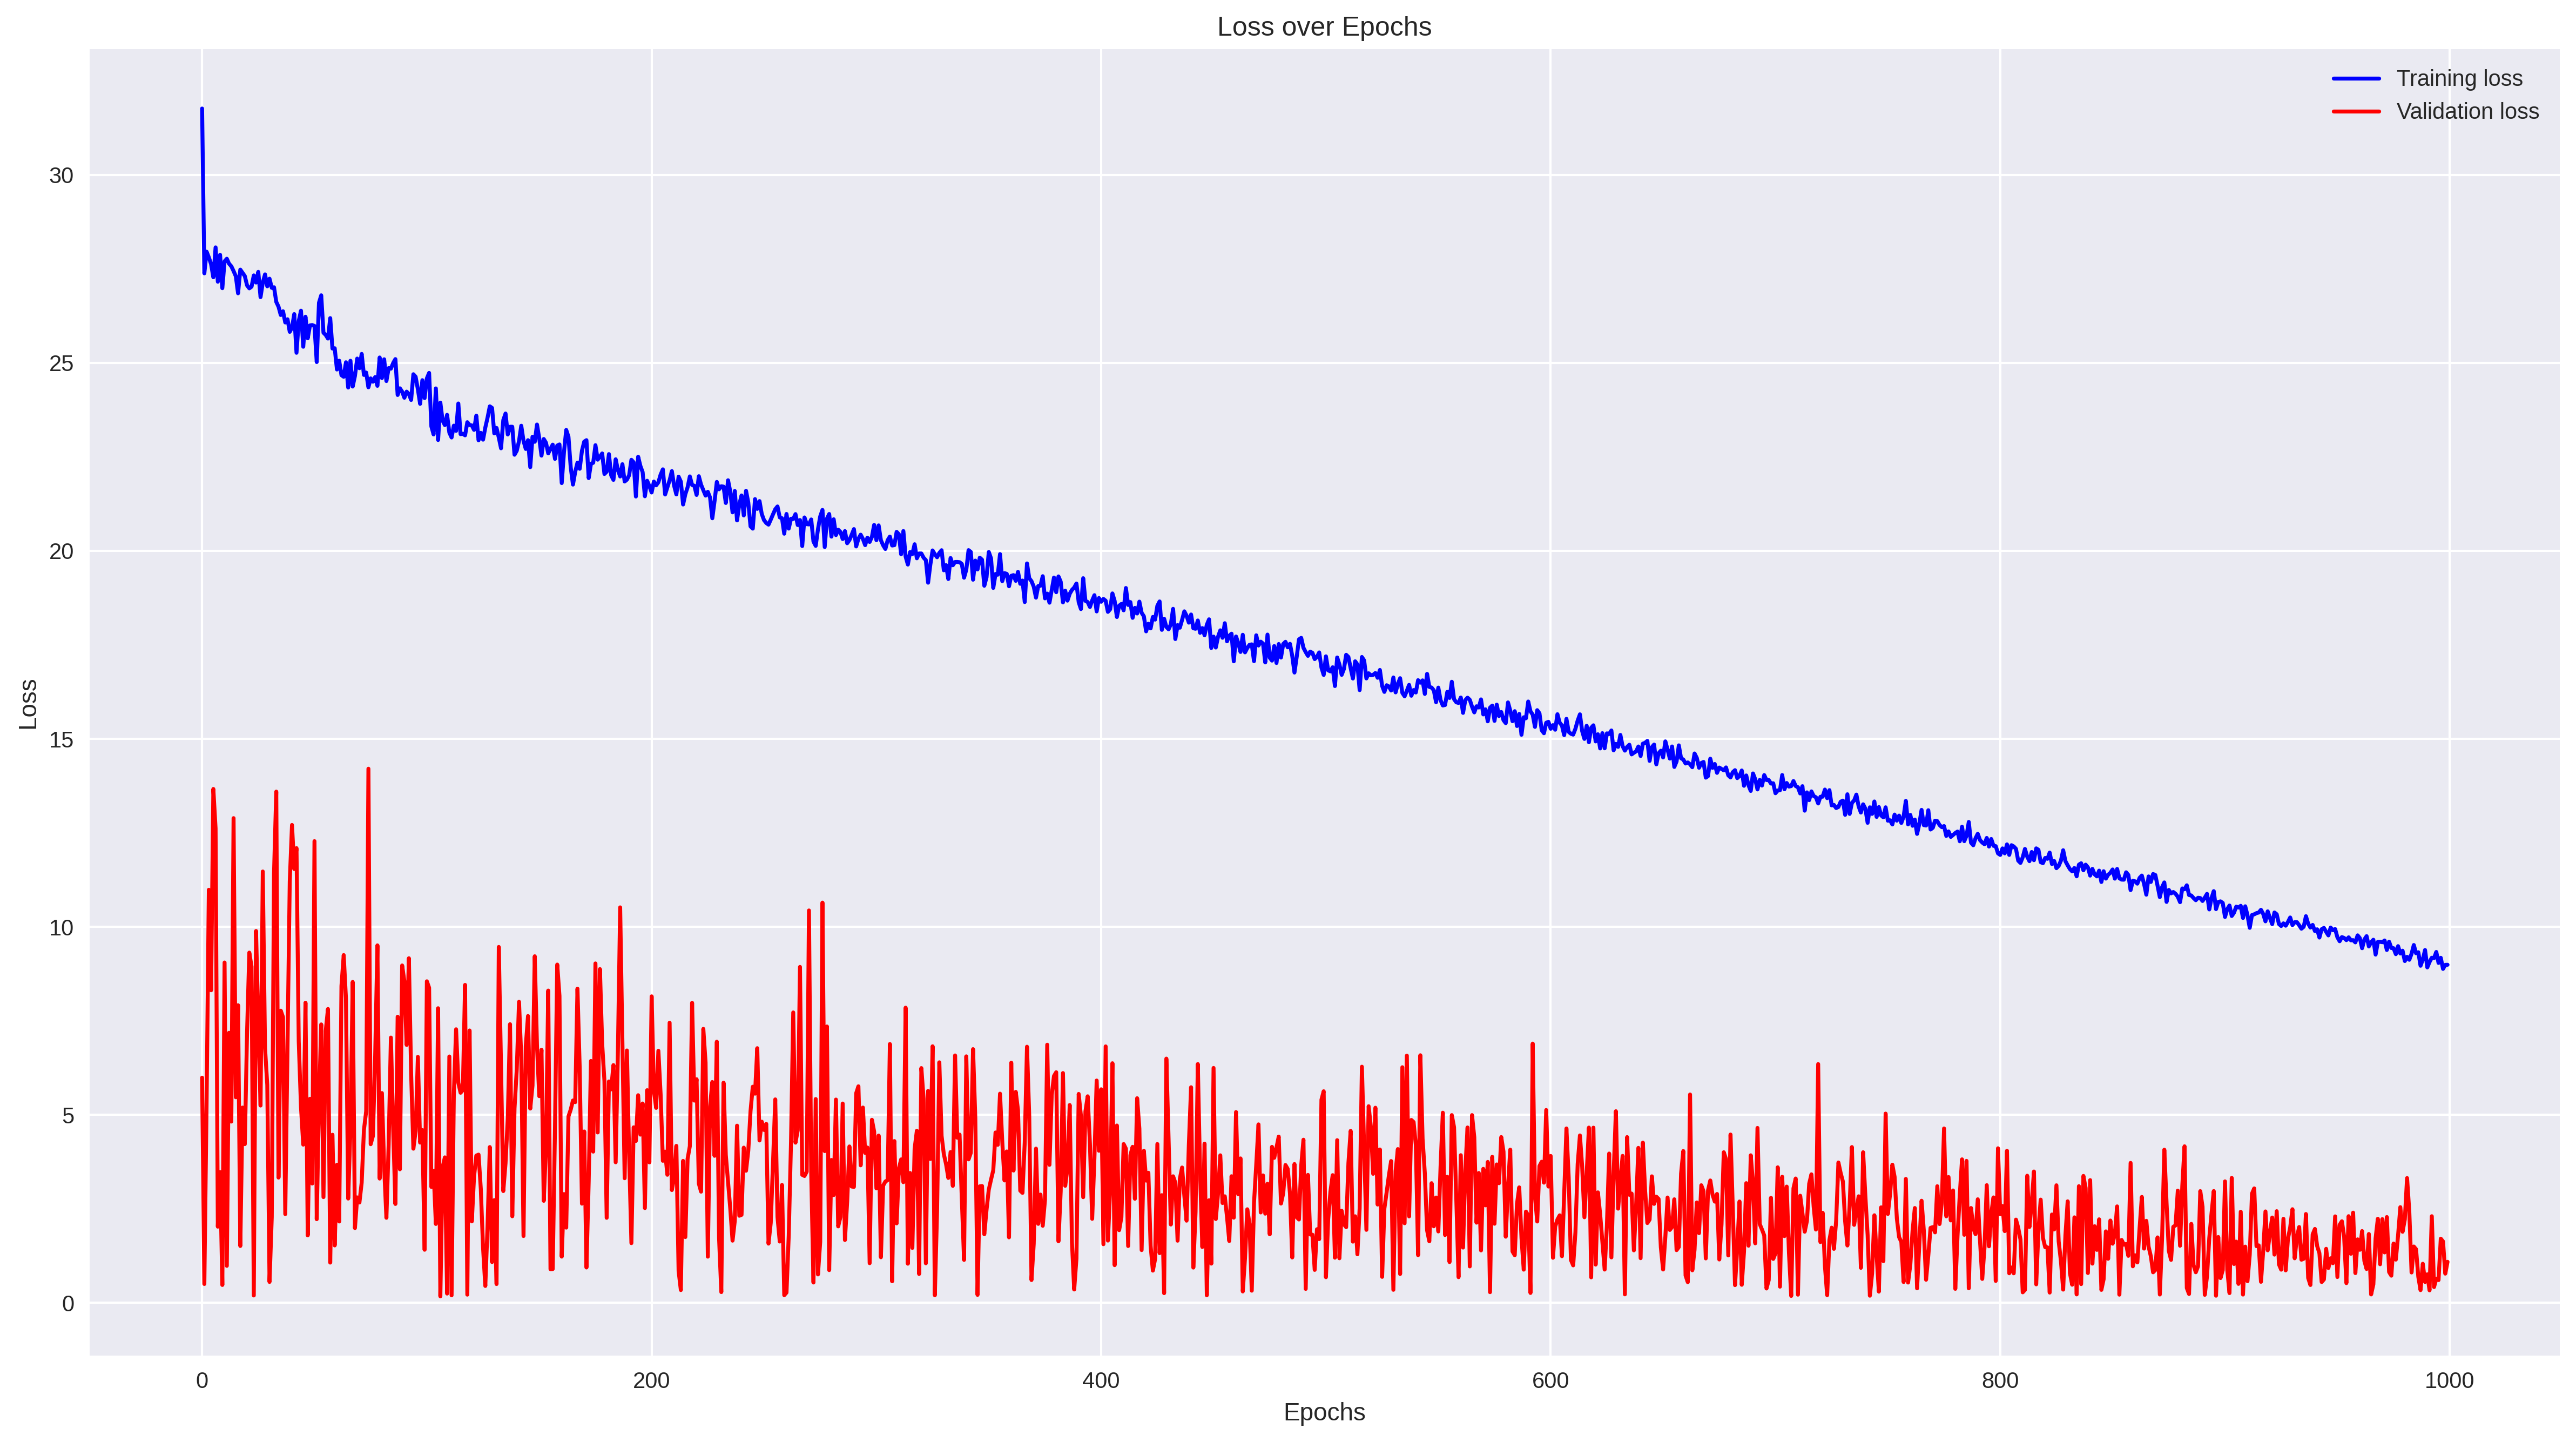

In [17]:
# 10. Plot the losses over epochs
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title = 'Loss over Epochs',
       xlabel = 'Epochs',
       ylabel = 'Loss')
ax.legend()
# plt.tight_layout()
# plt.savefig('CNNLosses.png')

In [18]:
# 11. Load model with lowes validation loss
state_dict = torch.load('cnn_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
# 12. Obtain predictions
y_pred = []
y_valid = []

with torch.no_grad():
  model.eval()
  for x_val, y_val in valid_loader:
    x_val = x_val.to(device)
    x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
    y_pred.append(model(x_val))
    y_valid.append(y_val)

y_pred = torch.cat(y_pred).cpu().numpy().flatten()
y_valid = torch.cat(y_valid).cpu().numpy().flatten()

CNN's forecast - MSE: 0.04, RMSE: 0.19


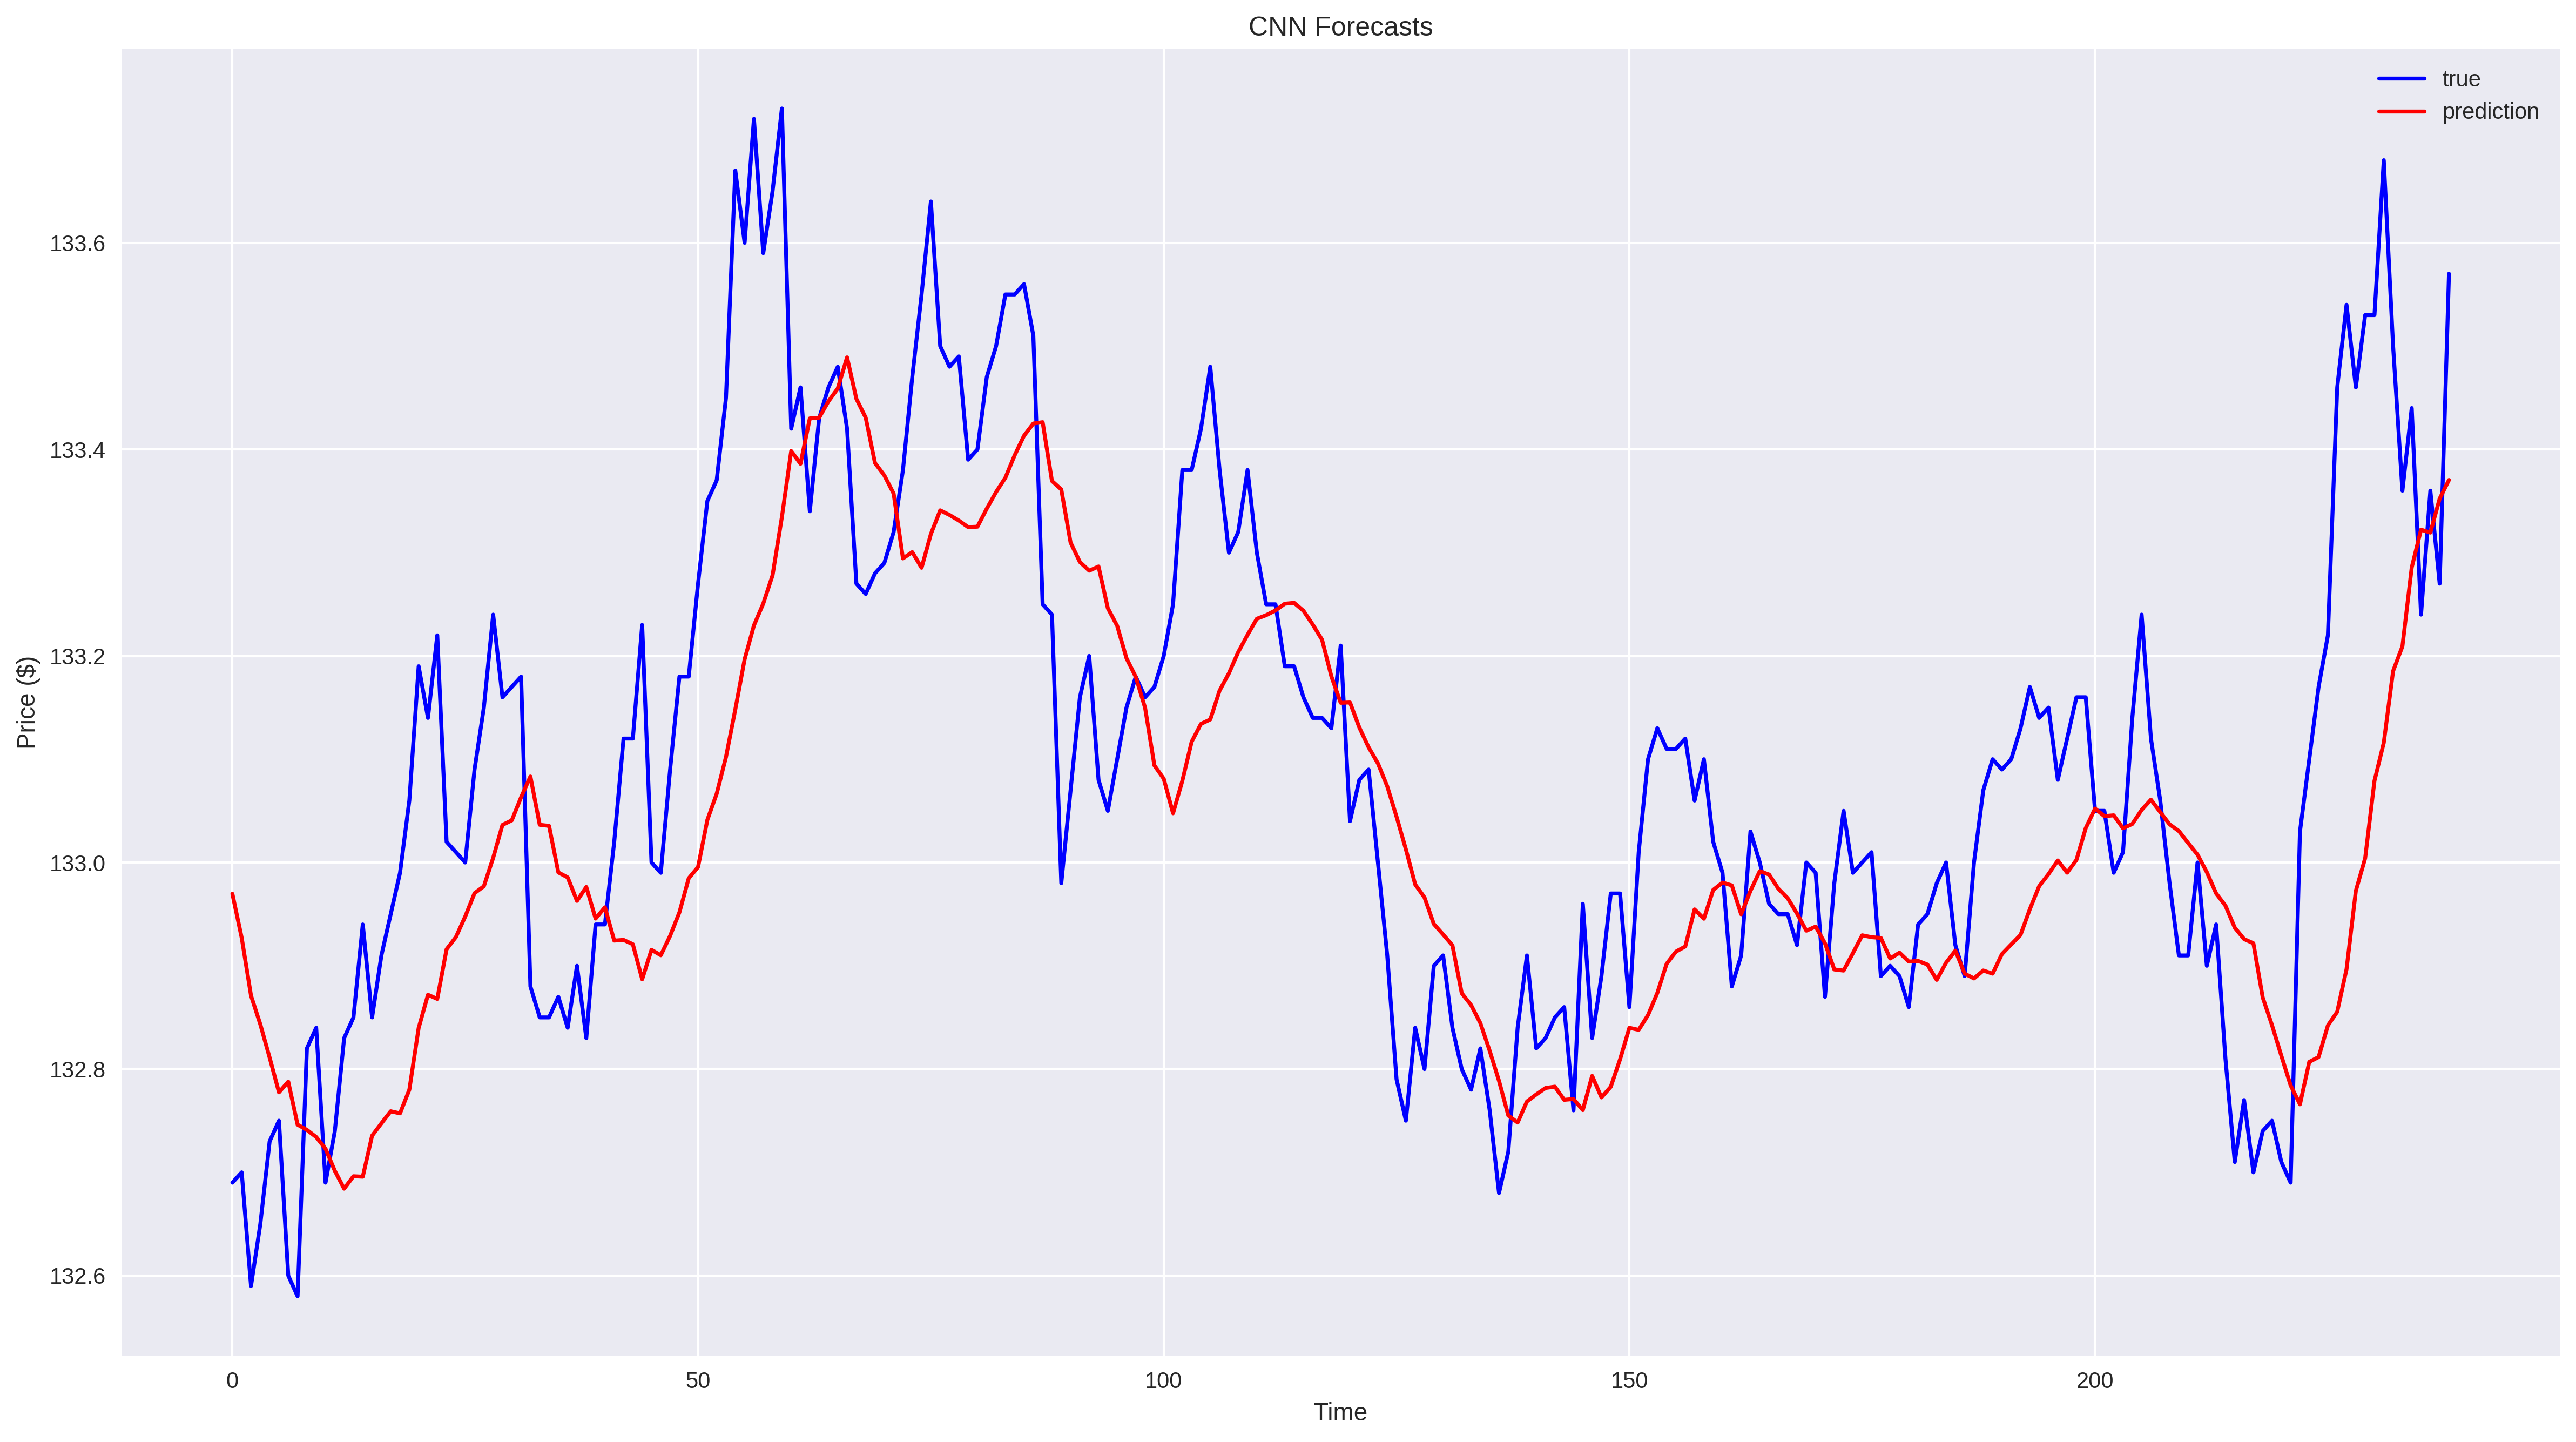

In [20]:
# 13. Evaluate predictions
cnn_mse = mean_squared_error(y_valid, y_pred)
cnn_rmse = np.sqrt(cnn_mse)
print("CNN's forecast - MSE: {:.2f}, RMSE: {:.2f}".format(cnn_mse, cnn_rmse))

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='true')
ax.plot(y_pred, color='red', label='prediction')

ax.set(title='CNN Forecasts',
       xlabel = 'Time',
       ylabel = 'Price ($)')
ax.legend()
# plt.tight_layout()
# plt.savefig('CNNForecast.png')